<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertAndInferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the first and second steps in the split workflow on Terra

DICOM files are downloaded and converted to NIFTI files. NIFTI files are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [2]:
%%capture
#Installing lz4 for compression/decompression; dcm2niix and plastimatch for conversion; 
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 xvfb dcm2niix pigz plastimatch ffmpeg

In [3]:
%%capture
#Installing Totalsegmentator for Inference
#pyradiomics required for extracting radiomics features 
#nvidia-ml-py3 for capturing gpu utilization
!pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [4]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

###Importing Packages

In [18]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
import nvidia_smi
import subprocess

In [6]:
curr_dir   = Path().absolute()

os.environ['TZ'] = 'US/Eastern'
time.tzset()
current_time = time.strftime('%a %b %d %H:%M:%S %Y', time.localtime())
print(current_time)
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Sat Apr 01 06:20:40 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Parameters for papermill

In [7]:
converterType='dcm2niix'
csvFilePath=''

###Reading CSV File containing s5cmd Urls

In [25]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.


#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path= '/home/vamsi/Downloads/result.csv'
#csvFilePath=csvFilePath.replace("gs://", "/cromwell_root/")

start_time = time.time()
#cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
cohort_df= pd.read_csv('/content/drive/MyDrive/idc/bq-results-20230315-160529-1678896367937.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.1649324893951416  seconds


In [51]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].sample(n=10).values.tolist()
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs=[ '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949'  
# ]

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Defining Functions

In [53]:
#Creating Directories for conversion
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [54]:
#create directory for TotalSegmentator Output files

try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [55]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat 

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [56]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [57]:
def check_dicom_conversion_errors(series_id_folder_path):
    nifti_files = os.listdir(series_id_folder_path)
    if len(nifti_files) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id_folder_path}\n")
        return True
    else:
        return False

In [58]:
def inferenceTotalSegmentator(series_id):

      start_time = time.time()
      download_dicom_data(series_id)
      dicom_download_time = time.time() - start_time      

      start_time = time.time()
      convert_dicom_to_nifti(series_id)
      dicom_conversion_time = time.time() - start_time     

      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')
      os.mkdir(f'metadata/{series_id}')

      print("Processing series: "+series_id)  


      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      
      if not check_dicom_conversion_errors(series_id_folder_path):

        # start_time = time.time()
        # !TotalSegmentator -i {nifti_filename_path} -o {curr_dir}/Inference/{series_id}/{series_id}.nii.gz --ml --fast --preview  --radiomics 
        # total_segmentator_time = time.time() - start_time

        # start_time = time.time()     
        # !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii.gz  {curr_dir}/Inference/{series_id}/{series_id}.nii.gz.lz4
        # archiving_time = time.time() - start_time


        start_time = time.time()
        !TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
        total_segmentator_time = time.time() - start_time

        try:
          subprocess.run(["mv", f"{curr_dir}/preview_total.png", f"{curr_dir}/segmentations.nii", f"{curr_dir}/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
          print("Files moved successfully using the first command")
        except subprocess.CalledProcessError:
          try:
            subprocess.run(["mv", "segmentations/preview_total.png", "segmentations/segmentations.nii", "segmentations/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
          except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")
        
        #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
        !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
        !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
        !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

        start_time = time.time()  
        !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
        !tar cvf - {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png | lz4 > {curr_dir}/metadata/{series_id}/{series_id}_metadata.tar.lz4
        archiving_time = time.time() - start_time

      else: 
        total_segmentator_time=0
        archiving_time=0

      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 

      log['dicom_download_time']=dicom_download_time
      log['dicom_conversion_time']=dicom_conversion_time            
      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time


      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [59]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

###Total Segmentator

Copying files from IDC buckets..
Done in 2.25281 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 437 DICOM file(s)
Convert 437 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.888080163484512818795463685371/1.3.6.1.4.1.14519.5.2.1.7009.9004.88808016348451281879546368537_2_OPA_GE_LS16_STANDARD_335_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x437x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.888080163484512818795463685371/1.3.6.1.4.1.14519.5.2.1.7009.9004.88808016348451281879546368537_2_OPA_GE_LS16_STANDARD_335_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 14.821223 seconds (0.840958 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.888080163484512818795463685371

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.60s
Predicting.

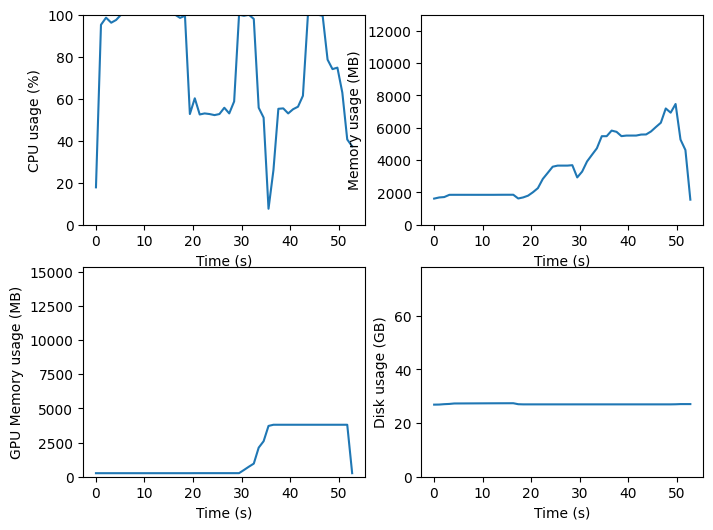

Copying files from IDC buckets..
Done in 1.44499 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 458 DICOM file(s)
Convert 458 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.143345374145684564044413089578/1.3.6.1.4.1.14519.5.2.1.7009.9004.14334537414568456404441308957_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x458x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.143345374145684564044413089578/1.3.6.1.4.1.14519.5.2.1.7009.9004.14334537414568456404441308957_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 15.554546 seconds (0.734710 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.143345374145684564044413089578

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.69s
Predicting.

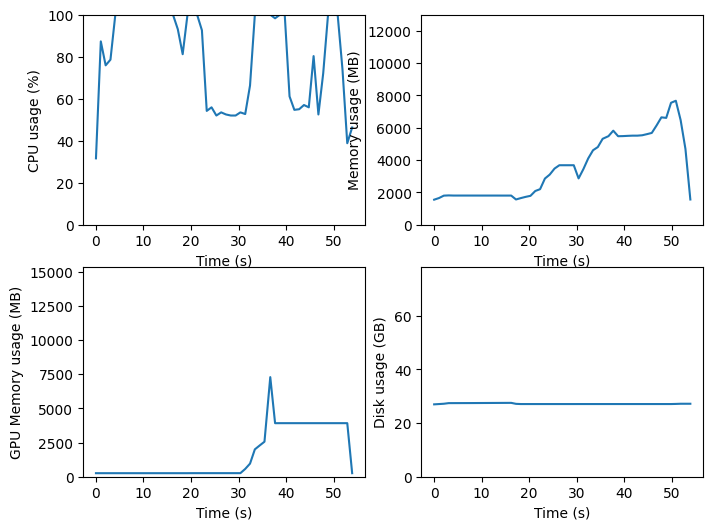

Copying files from IDC buckets..
Done in 1.4313 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 425 DICOM file(s)
Convert 425 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.124508669744633930569277380162/1.3.6.1.4.1.14519.5.2.1.7009.9004.12450866974463393056927738016_2_OPA_GE_LS16_STANDARD_310_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x425x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.124508669744633930569277380162/1.3.6.1.4.1.14519.5.2.1.7009.9004.12450866974463393056927738016_2_OPA_GE_LS16_STANDARD_310_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 14.324849 seconds (0.691973 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.124508669744633930569277380162

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.87s
Predicting..

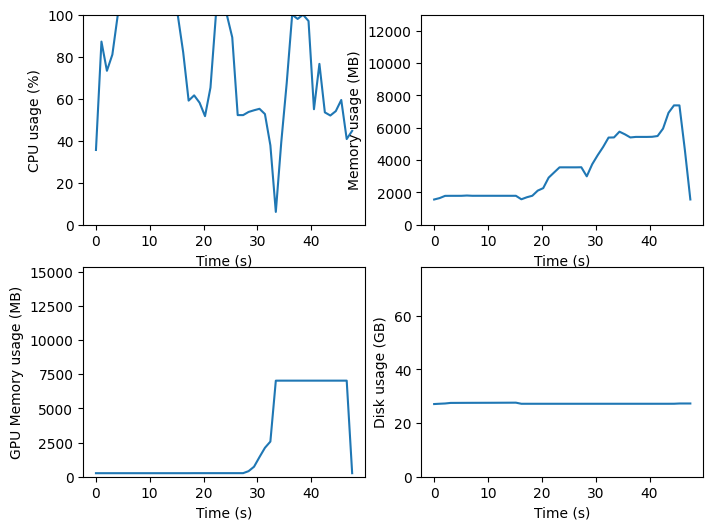

Copying files from IDC buckets..
Done in 1.94672 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 461 DICOM file(s)
Convert 461 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.219560547627668013150601856497/1.3.6.1.4.1.14519.5.2.1.7009.9004.21956054762766801315060185649_2_OPA_GE_LS16_STANDARD_360_1.2_120_80_58.2_1.4_20010102000000_3 (512x512x461x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.219560547627668013150601856497/1.3.6.1.4.1.14519.5.2.1.7009.9004.21956054762766801315060185649_2_OPA_GE_LS16_STANDARD_360_1.2_120_80_58.2_1.4_20010102000000_3.nii"
Conversion required 11.587923 seconds (0.857058 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.219560547627668013150601856497

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.69s
Predicting.

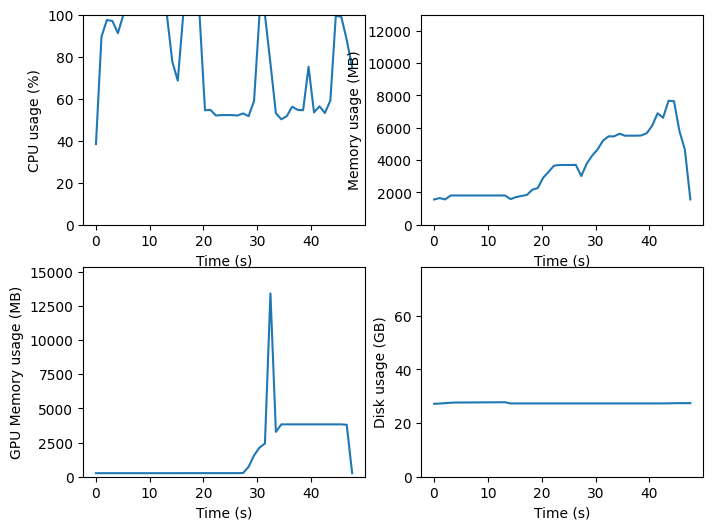

Copying files from IDC buckets..
Done in 1.22378 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 404 DICOM file(s)
Convert 404 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694/1.3.6.1.4.1.14519.5.2.1.7009.9004.22274200237969142249705030269_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x404x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694/1.3.6.1.4.1.14519.5.2.1.7009.9004.22274200237969142249705030269_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 14.234084 seconds (0.674156 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.71s
Predicting.

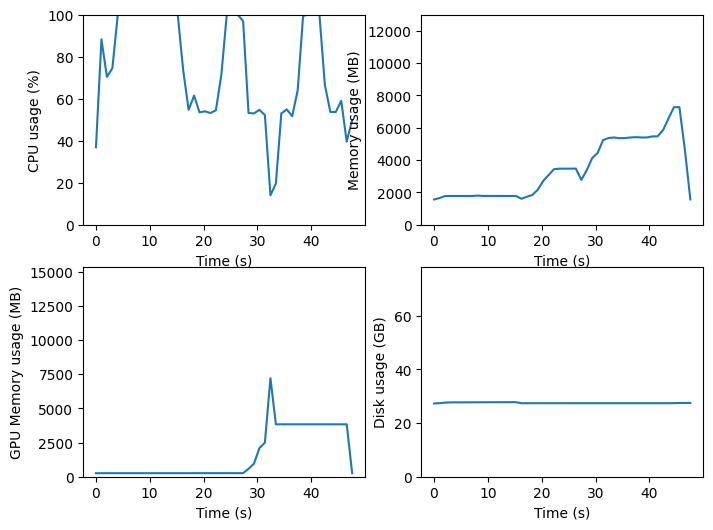

Copying files from IDC buckets..
Done in 1.53035 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 493 DICOM file(s)
Convert 493 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/1.3.6.1.4.1.14519.5.2.1.7009.9004.54079167104762832009527858602_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3 (512x512x493x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/1.3.6.1.4.1.14519.5.2.1.7009.9004.54079167104762832009527858602_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3.nii"
Conversion required 16.168299 seconds (0.789628 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.24s
Predict

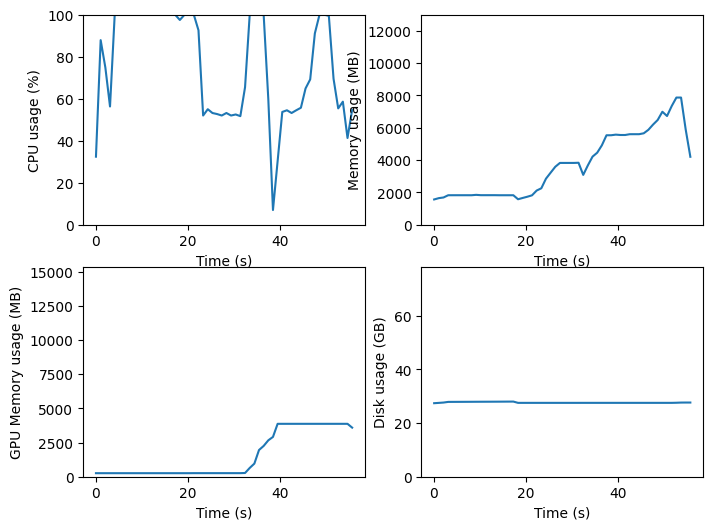

Copying files from IDC buckets..
Done in 1.3274 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 411 DICOM file(s)
Convert 411 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.294469317306943237266917376178/1.3.6.1.4.1.14519.5.2.1.7009.9004.29446931730694323726691737617_2_OPA_GE_LS16_STANDARD_330_1.2_120_70_50.9_1.4_20010102000000_3 (512x512x411x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.294469317306943237266917376178/1.3.6.1.4.1.14519.5.2.1.7009.9004.29446931730694323726691737617_2_OPA_GE_LS16_STANDARD_330_1.2_120_70_50.9_1.4_20010102000000_3.nii"
Conversion required 14.311547 seconds (0.665544 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.294469317306943237266917376178

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.18s
Predicting..

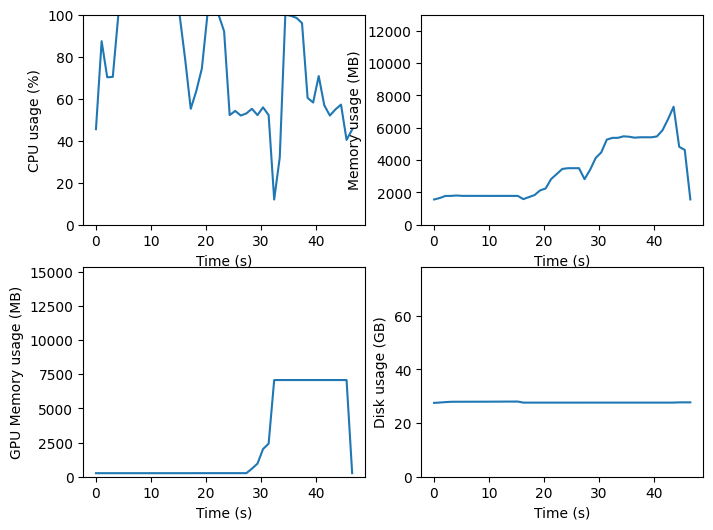

Copying files from IDC buckets..
Done in 2.05298 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 422 DICOM file(s)
Convert 422 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.530549921346138554683297615791/1.3.6.1.4.1.14519.5.2.1.7009.9004.53054992134613855468329761579_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x422x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.530549921346138554683297615791/1.3.6.1.4.1.14519.5.2.1.7009.9004.53054992134613855468329761579_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 13.778966 seconds (0.799806 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.530549921346138554683297615791

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.06s
Predicting.

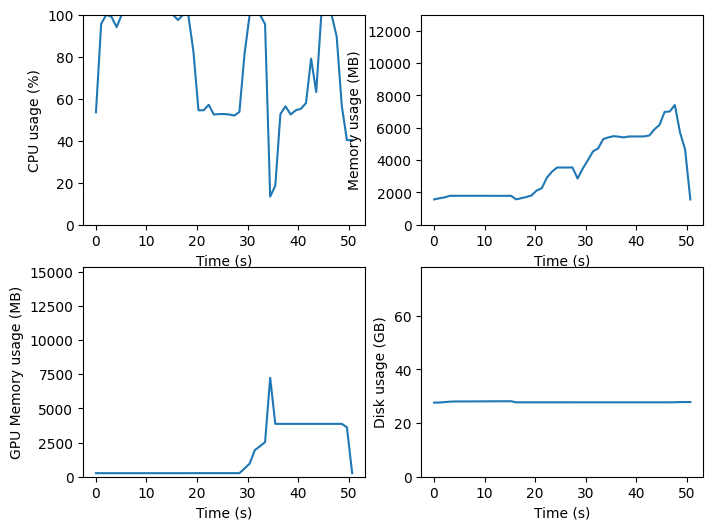

Copying files from IDC buckets..
Done in 1.42572 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 461 DICOM file(s)
Convert 461 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304615677708118002304/1.3.6.1.4.1.14519.5.2.1.7009.9004.16227442730461567770811800230_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3 (512x512x461x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304615677708118002304/1.3.6.1.4.1.14519.5.2.1.7009.9004.16227442730461567770811800230_1_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20000102000000_3.nii"
Conversion required 13.315199 seconds (0.741417 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304615677708118002304

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.47s
Predict

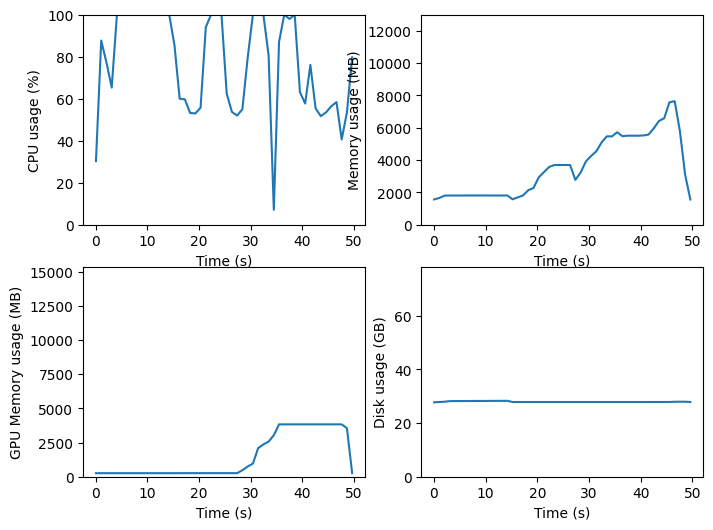

Copying files from IDC buckets..
Done in 1.84213 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 442 DICOM file(s)
Convert 442 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.859571321741938678331005642718/1.3.6.1.4.1.14519.5.2.1.7009.9004.85957132174193867833100564271_0_OPA_GE_LSPR16_STANDARD_310_1.2_120_80_58.2_1.4_19990102000000_3 (512x512x442x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.859571321741938678331005642718/1.3.6.1.4.1.14519.5.2.1.7009.9004.85957132174193867833100564271_0_OPA_GE_LSPR16_STANDARD_310_1.2_120_80_58.2_1.4_19990102000000_3.nii"
Conversion required 14.931832 seconds (0.722895 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.859571321741938678331005642718

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.73s
Predict

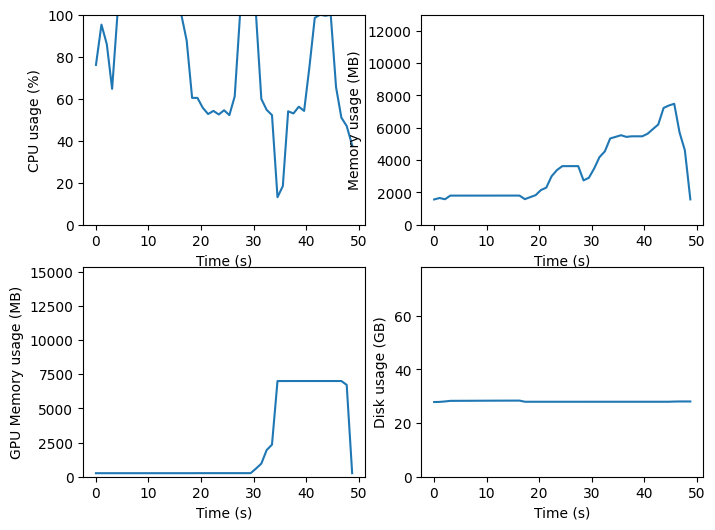

In [60]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time','dicom_download_time','dicom_conversion_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
    #for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [61]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
!tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
output_file_archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023_statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023_preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023/1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047628320095278586023.nii
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694.nii
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691422497050302694_statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379691

###Utilization Metrics

In [62]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_file_archiving_time']=output_file_archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 27821 bytes into 10973 bytes ==> 39.44%


,SeriesInstanceUID,total_segmentator_time,dicom_download_time,dicom_conversion_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total,output_file_archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.888080163484...,35.070484,2.389434,14.959246,0.236916,"[[[17.8, 95.2, 98.6, 96.2, 97.5, 100.0, 100.0,...","[[[1615.109375, 1685.22265625, 1710.6328125, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.83978271484375, 26.869434356689453, 27.0...",78.189842,3.763483
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.143345374145...,36.488838,1.570415,15.663690,0.238693,"[[[31.6, 87.3, 75.9, 78.6, 100.0, 100.0, 100.0...","[[[1548.52734375, 1649.1875, 1798.9921875, 181...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.946937561035156, 27.058197021484375, 27....",78.189842,3.763483
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.124508669744...,31.360816,1.560056,14.477283,0.240746,"[[[35.6, 87.2, 73.3, 81.0, 100.0, 100.0, 100.0...","[[[1559.48046875, 1647.328125, 1784.37109375, ...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.059253692626953, 27.17156982421875, 27.2...",78.189842,3.763483
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.219560547627...,33.574626,2.073350,11.754461,0.241708,"[[[38.4, 89.5, 97.5, 97.0, 91.2, 100.0, 100.0,...","[[[1560.70703125, 1648.1953125, 1564.01953125,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.16344451904297, 27.247486114501953, 27.3...",78.189842,3.763483
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.222742002379...,31.676643,1.353206,14.383212,0.238083,"[[[36.9, 88.3, 70.4, 74.5, 100.0, 100.0, 100.0...","[[[1561.640625, 1652.05859375, 1775.4609375, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.276397705078125, 27.404869079589844, 27....",78.189842,3.763483
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.540791671047...,37.926352,1.665107,16.355262,0.233017,"[[[32.4, 87.9, 74.9, 56.3, 100.0, 100.0, 100.0...","[[[1562.44140625, 1644.6328125, 1684.62109375,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.375408172607422, 27.493057250976562, 27....",78.189842,3.763483
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.294469317306...,30.370885,1.462594,14.475200,0.247267,"[[[45.5, 87.4, 70.2, 70.4, 100.0, 100.0, 100.0...","[[[1563.2421875, 1651.51953125, 1780.15625, 17...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.496200561523438, 27.6129150390625, 27.78...",78.189842,3.763483
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.530549921346...,33.869237,2.197099,13.971559,0.236329,"[[[53.5, 95.7, 100.0, 99.0, 94.1, 100.0, 100.0...","[[[1563.69140625, 1635.61328125, 1689.87890625...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.596935272216797, 27.616806030273438, 27....",78.189842,3.763483
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.162274427304...,33.695818,1.553787,13.502807,0.240686,"[[[30.3, 87.7, 77.2, 65.3, 100.0, 100.0, 100.0...","[[[1563.46484375, 1656.40625, 1803.21484375, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.700420379638672, 27.82382583618164, 27.9...",78.189842,3.763483
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.859571321741...,30.929353,2.002638,15.024970,0.242800,"[[[76.1, 95.3, 86.0, 64.7, 100.0, 100.0, 100.0...","[[[1561.65625, 1652.0546875, 1573.69921875, 17...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[27.813392639160156, 27.85814666748047, 28.0...",78.189842,3.763483
